In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Current date (May 1 for this simulation)
current_date = datetime(2025, 5, 1)

# Asset parameters dictionary
assets = {
    "GOLD": {
        "spot": 9436.00,
        "volatility": 0.18,  # 18% annualized
        "dividend_yield": 0.00,  # No dividends
    },
    "OIL": {
        "spot": 5007.38,  #Crude oil
        "volatility": 0.32,  # 32% annualized
        "dividend_yield": 0.00,  # No dividends
    },
    "BITCOIN": {
        "spot": 8216447.00,
        "volatility": 0.53,  # 53% annualized
        "dividend_yield": 0.00,  # No dividends
    },
    "ICICI_BANK": {
        "spot": 1430.10,  # INR/share
        "volatility": 0.21,  # 21% annualized
        "dividend_yield": 0.007,  # 0.7% dividend yield
    }
}

# Common parameters
risk_free_rate = 0.0635  #annual risk-free rate
time_to_maturity = 1

In [2]:
# Define strikes for each asset
for asset in assets:
    spot = assets[asset]["spot"]

    # ATM strike = spot price
    assets[asset]["strike_ATM"] = spot

    # ITM strike (10% below spot for calls, above for puts)
    assets[asset]["strike_ITM_call"] = spot * 0.9
    assets[asset]["strike_ITM_put"] = spot * 1.1

    # OTM strike (10% above spot for calls, below for puts)
    assets[asset]["strike_OTM_call"] = spot * 1.1
    assets[asset]["strike_OTM_put"] = spot * 0.9

In [3]:
def generate_price_paths(S0, sigma, r, q, T, n_steps, n_simulations):

    np.random.seed(42)
    dt = T / n_steps
    paths = np.zeros((n_simulations, n_steps + 1))
    paths[:, 0] = S0

    for t in range(1, n_steps + 1):
        z = np.random.standard_normal(n_simulations)
        paths[:, t] = paths[:, t-1] * np.exp((r - q - 0.5 * sigma**2) * dt
                                            + sigma * np.sqrt(dt) * z)

    return paths

# Simulation parameters
#n_steps = 100  # Number of time steps
#n_simulations = 10000  # Number of simulations

In [4]:
def floating_strike_lookback(paths, option_type, r, T):

    if option_type == 'call':
        # Call payoff: S_T - min(S)
        min_prices = np.min(paths, axis=1)
        payoffs = paths[:, -1] - min_prices
    elif option_type == 'put':
        # Put payoff: max(S) - S_T
        max_prices = np.max(paths, axis=1)
        payoffs = max_prices - paths[:, -1]
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Discounted average payoff
    price = np.exp(-r * T) * np.mean(payoffs)
    std_error = np.std(payoffs, ddof=1) / np.sqrt(len(payoffs))

    return price,std_error

In [5]:
def fixed_strike_lookback(paths, option_type, K, r, T):

    if option_type == 'call':
        # Call payoff: max(max(S) - K, 0)
        max_prices = np.max(paths, axis=1)
        payoffs = np.maximum(max_prices - K, 0)
    elif option_type == 'put':
        # Put payoff: max(K - min(S), 0)
        min_prices = np.min(paths, axis=1)
        payoffs = np.maximum(K - min_prices, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Discounted average payoff
    price = np.exp(-r * T) * np.mean(payoffs)
    std_error = np.std(payoffs, ddof=1) / np.sqrt(len(payoffs))
    return price,std_error

In [6]:
risk_free_rate = 0.0635
time_to_maturity = 1
n_steps = 252
simulation_sizes = [1000, 5000, 10000, 20000]

# 7. Loop over simulation sizes
all_results = []

for n_simulations in simulation_sizes:
    for asset_name, params in assets.items():
        S0 = params["spot"]
        sigma = params["volatility"]
        q = params["dividend_yield"]
        K = params["strike_ATM"]

        # Generate paths
        paths = generate_price_paths(S0, sigma, risk_free_rate, q, time_to_maturity, n_steps, n_simulations)

        # Floating strike
        float_call, float_call_se = floating_strike_lookback(paths, 'call', risk_free_rate, time_to_maturity)
        float_put, float_put_se = floating_strike_lookback(paths, 'put', risk_free_rate, time_to_maturity)

        # Fixed strike
        fixed_call, fixed_call_se = fixed_strike_lookback(paths, 'call', K, risk_free_rate, time_to_maturity)
        fixed_put, fixed_put_se = fixed_strike_lookback(paths, 'put', K, risk_free_rate, time_to_maturity)

        # Store results in "price ± SE" format
        all_results.append({
            "Simulations": n_simulations,
            "Asset": asset_name,
            "Floating Call": f"{float_call:.4f} ± {float_call_se:.4f}",
            "Floating Put": f"{float_put:.4f} ± {float_put_se:.4f}",
            "Fixed Call": f"{fixed_call:.4f} ± {fixed_call_se:.4f}",
            "Fixed Put": f"{fixed_put:.4f} ± {fixed_put_se:.4f}"
        })

# 8. Display results
df_results = pd.DataFrame(all_results)
print(df_results)


    Simulations       Asset               Floating Call  \
0          1000        GOLD         1511.8277 ± 43.0430   
1          1000         OIL         1242.2415 ± 42.0967   
2          1000     BITCOIN  3022005.0829 ± 127018.6021   
3          1000  ICICI_BANK           250.2455 ± 7.5084   
4          5000        GOLD         1478.4464 ± 18.4334   
5          5000         OIL         1210.0565 ± 17.8463   
6          5000     BITCOIN   2916297.1902 ± 53337.6531   
7          5000  ICICI_BANK           244.5315 ± 3.2052   
8         10000        GOLD         1499.7571 ± 13.2644   
9         10000         OIL         1231.2458 ± 12.9004   
10        10000     BITCOIN   2981543.2643 ± 38659.7553   
11        10000  ICICI_BANK           248.2755 ± 2.3102   
12        20000        GOLD          1508.4255 ± 9.5175   
13        20000         OIL          1240.8586 ± 9.3200   
14        20000     BITCOIN   3018079.3425 ± 28234.4533   
15        20000  ICICI_BANK           249.8137 ± 1.6605 

In [7]:
# Modified result list to show "price ± error" format
fixed_strike_moneyness_results = []

# Simulation parameters
risk_free_rate = 0.0635
time_to_maturity = 1
n_steps = 252
n_simulations = 10000  # You can vary this if needed

# Loop through each asset
for asset_name, params in assets.items():
    S0 = params["spot"]
    sigma = params["volatility"]
    q = params["dividend_yield"]

    # Define strike variants
    strikes = {
        "ATM": S0,
        "ITM_call": params["strike_ITM_call"],
        "OTM_call": params["strike_OTM_call"],
        "ITM_put": params["strike_ITM_put"],
        "OTM_put": params["strike_OTM_put"]
    }

    # Generate price paths
    paths = generate_price_paths(S0, sigma, risk_free_rate, q, time_to_maturity, n_steps, n_simulations)

    # Fixed Strike Lookback Call options (ATM, ITM, OTM)
    for label, K in [("ATM", strikes["ATM"]),
                     ("ITM", strikes["ITM_call"]),
                     ("OTM", strikes["OTM_call"])]:
        price, se = fixed_strike_lookback(paths, 'call', K, risk_free_rate, time_to_maturity)
        fixed_strike_moneyness_results.append({
            "Asset": asset_name,
            "Option Type": "Call",
            "Moneyness": label,
            "Strike": round(K, 2),
            "Price ± Error": f"{price:.4f} ± {se:.4f}"
        })

    # Fixed Strike Lookback Put options (ATM, ITM, OTM)
    for label, K in [("ATM", strikes["ATM"]),
                     ("ITM", strikes["ITM_put"]),
                     ("OTM", strikes["OTM_put"])]:
        price, se = fixed_strike_lookback(paths, 'put', K, risk_free_rate, time_to_maturity)
        fixed_strike_moneyness_results.append({
            "Asset": asset_name,
            "Option Type": "Put",
            "Moneyness": label,
            "Strike": round(K, 2),
            "Price ± Error": f"{price:.4f} ± {se:.4f}"
        })

# Create DataFrame
df_moneyness = pd.DataFrame(fixed_strike_moneyness_results)
print(df_moneyness)


         Asset Option Type Moneyness      Strike              Price ± Error
0         GOLD        Call       ATM     9436.00        1627.4460 ± 13.8209
1         GOLD        Call       ITM     8492.40        2512.9902 ± 13.8209
2         GOLD        Call       OTM    10379.60         905.0589 ± 12.2024
3         GOLD         Put       ATM     9436.00          932.4289 ± 7.8686
4         GOLD         Put       ITM    10379.60         1817.9731 ± 7.8686
5         GOLD         Put       OTM     8492.40          320.4696 ± 5.5333
6          OIL        Call       ATM     5007.38        1446.2020 ± 14.0011
7          OIL        Call       ITM     4506.64        1916.1317 ± 14.0011
8          OIL        Call       OTM     5508.12        1043.5757 ± 13.3397
9          OIL         Put       ATM     5007.38          936.5157 ± 7.0025
10         OIL         Put       ITM     5508.12         1406.4453 ± 7.0025
11         OIL         Put       OTM     4506.64          541.9481 ± 6.1217
12     BITCO

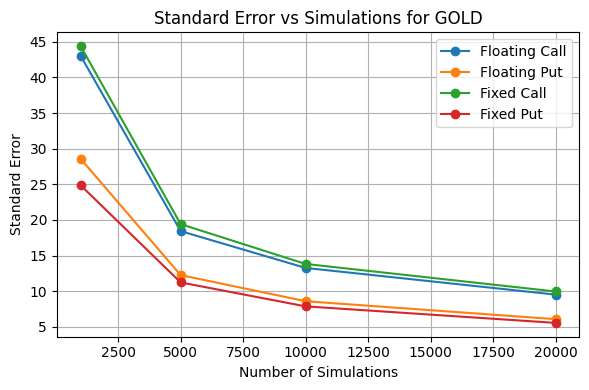

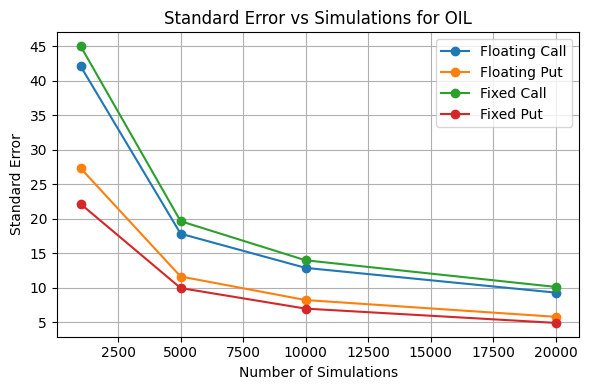

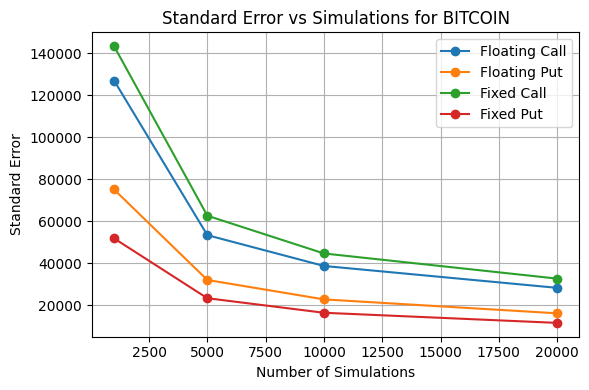

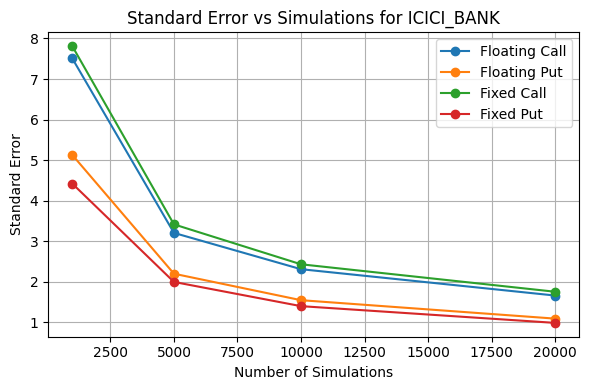

In [8]:
import matplotlib.pyplot as plt

# Step 1: Prepare a dictionary to store errors per asset
asset_errors = {}

for row in all_results:
    asset = row["Asset"]
    n_sim = row["Simulations"]

    if asset not in asset_errors:
        asset_errors[asset] = {
            "Floating Call": [],
            "Floating Put": [],
            "Fixed Call": [],
            "Fixed Put": []
        }

    for opt_type in asset_errors[asset]:
        std_error = float(row[opt_type].split("±")[1].strip())
        asset_errors[asset][opt_type].append((n_sim, std_error))

# Step 2: Plot for each asset
for asset, option_errors in asset_errors.items():
    plt.figure(figsize=(6, 4))
    for opt_type, data in option_errors.items():
        sims, errors = zip(*sorted(data))
        plt.plot(sims, errors, marker='o', label=opt_type)

    plt.title(f'Standard Error vs Simulations for {asset}')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Standard Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


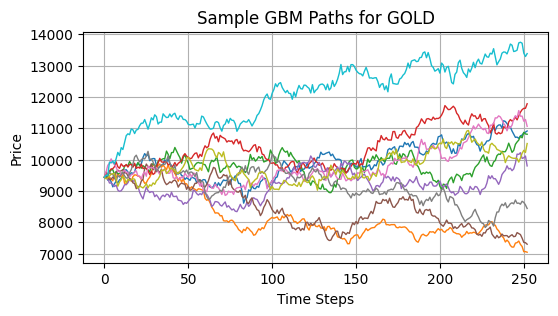

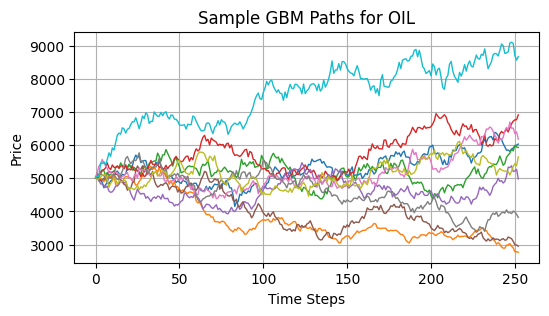

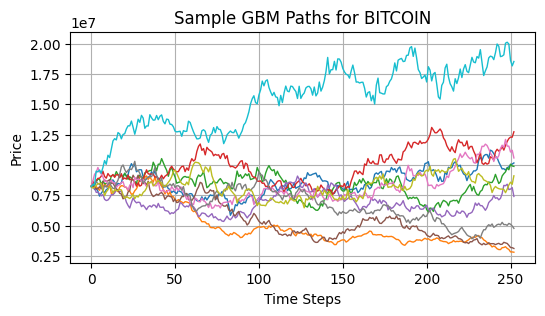

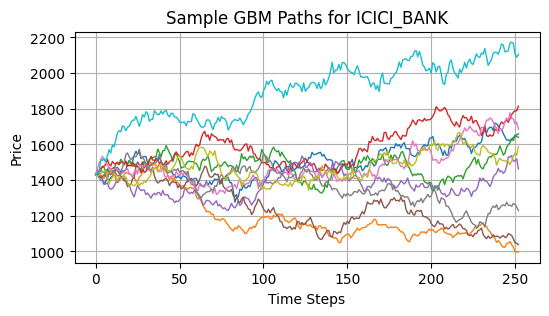

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sample_paths(asset_name, paths, num_paths=10):
    """
    Plot sample price paths for a given asset
    """
    plt.figure(figsize=(6, 3))
    for i in range(min(num_paths, paths.shape[0])):
        plt.plot(paths[i], lw=1)

    plt.title(f'Sample GBM Paths for {asset_name}')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

# Generate and plot paths for each asset
for asset_name, params in assets.items():
    paths = generate_price_paths(params["spot"], params["volatility"],
                               risk_free_rate, params["dividend_yield"],
                               time_to_maturity, n_steps, 100)  # 100 paths for visualization
    plot_sample_paths(asset_name, paths)

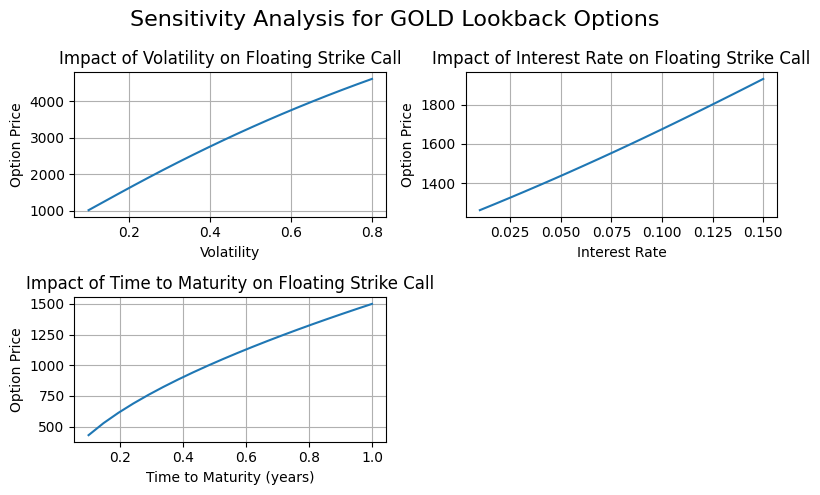

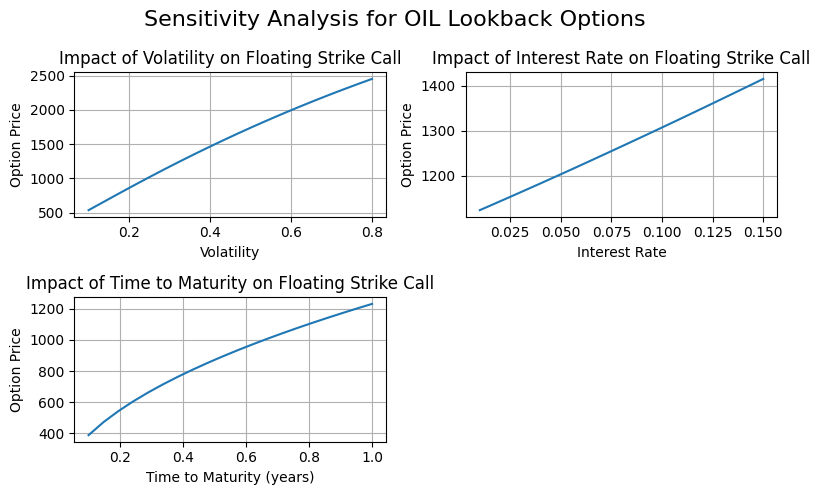

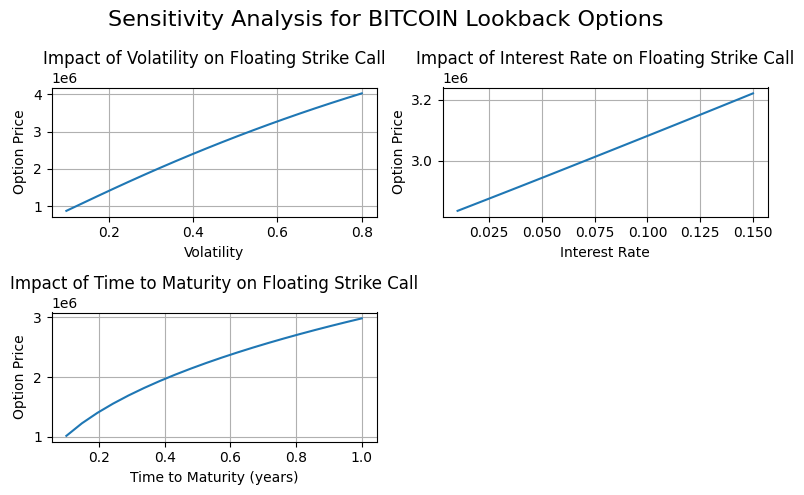

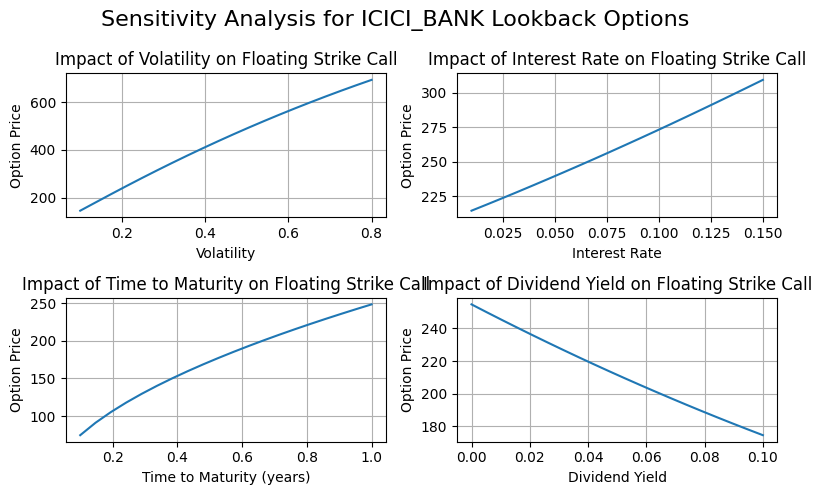

In [10]:
def plot_sensitivity_analysis(asset_name):
    """
    Perform and plot sensitivity analysis for key parameters
    """
    base_params = assets[asset_name]

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(8, 5))
    fig.suptitle(f'Sensitivity Analysis for {asset_name} Lookback Options', fontsize=16)

    # 1. Volatility Sensitivity
    volatilities = np.linspace(0.1, 0.8, 20)
    vol_prices = []
    for vol in volatilities:
        paths = generate_price_paths(base_params["spot"], vol, risk_free_rate,
                                  base_params["dividend_yield"], time_to_maturity,
                                  n_steps, n_simulations)
        price,std = floating_strike_lookback(paths, 'call', risk_free_rate, time_to_maturity)
        vol_prices.append(price)

    axes[0, 0].plot(volatilities, vol_prices)
    axes[0, 0].set_title('Impact of Volatility on Floating Strike Call')
    axes[0, 0].set_xlabel('Volatility')
    axes[0, 0].set_ylabel('Option Price')
    axes[0, 0].grid(True)

    # 2. Interest Rate Sensitivity
    rates = np.linspace(0.01, 0.15, 20)
    rate_prices = []
    for r in rates:
        paths = generate_price_paths(base_params["spot"], base_params["volatility"],
                                  r, base_params["dividend_yield"], time_to_maturity,
                                  n_steps, n_simulations)
        price,std = floating_strike_lookback(paths, 'call', r, time_to_maturity)
        rate_prices.append(price)

    axes[0, 1].plot(rates, rate_prices)
    axes[0, 1].set_title('Impact of Interest Rate on Floating Strike Call')
    axes[0, 1].set_xlabel('Interest Rate')
    axes[0, 1].set_ylabel('Option Price')
    axes[0, 1].grid(True)

    # 3. Time to Maturity Sensitivity
    times = np.linspace(0.1, 1.0, 20)
    time_prices = []
    for t in times:
        paths = generate_price_paths(base_params["spot"], base_params["volatility"],
                                  risk_free_rate, base_params["dividend_yield"], t,
                                  n_steps, n_simulations)
        price,std= floating_strike_lookback(paths, 'call', risk_free_rate, t)
        time_prices.append(price)

    axes[1, 0].plot(times, time_prices)
    axes[1, 0].set_title('Impact of Time to Maturity on Floating Strike Call')
    axes[1, 0].set_xlabel('Time to Maturity (years)')
    axes[1, 0].set_ylabel('Option Price')
    axes[1, 0].grid(True)

    # 4. Dividend Yield Sensitivity (only for ICICI Bank)
    if asset_name == "ICICI_BANK":
        dividends = np.linspace(0.0, 0.1, 20)
        div_prices = []
        for q in dividends:
            paths = generate_price_paths(base_params["spot"], base_params["volatility"],
                                      risk_free_rate, q, time_to_maturity,
                                      n_steps, n_simulations)
            price,std = floating_strike_lookback(paths, 'call', risk_free_rate, time_to_maturity)
            div_prices.append(price)

        axes[1, 1].plot(dividends, div_prices)
        axes[1, 1].set_title('Impact of Dividend Yield on Floating Strike Call')
        axes[1, 1].set_xlabel('Dividend Yield')
        axes[1, 1].set_ylabel('Option Price')
        axes[1, 1].grid(True)
    else:
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Run sensitivity analysis for each asset
for asset_name in assets:
    plot_sensitivity_analysis(asset_name)

NameError: name 'spot_prices' is not defined

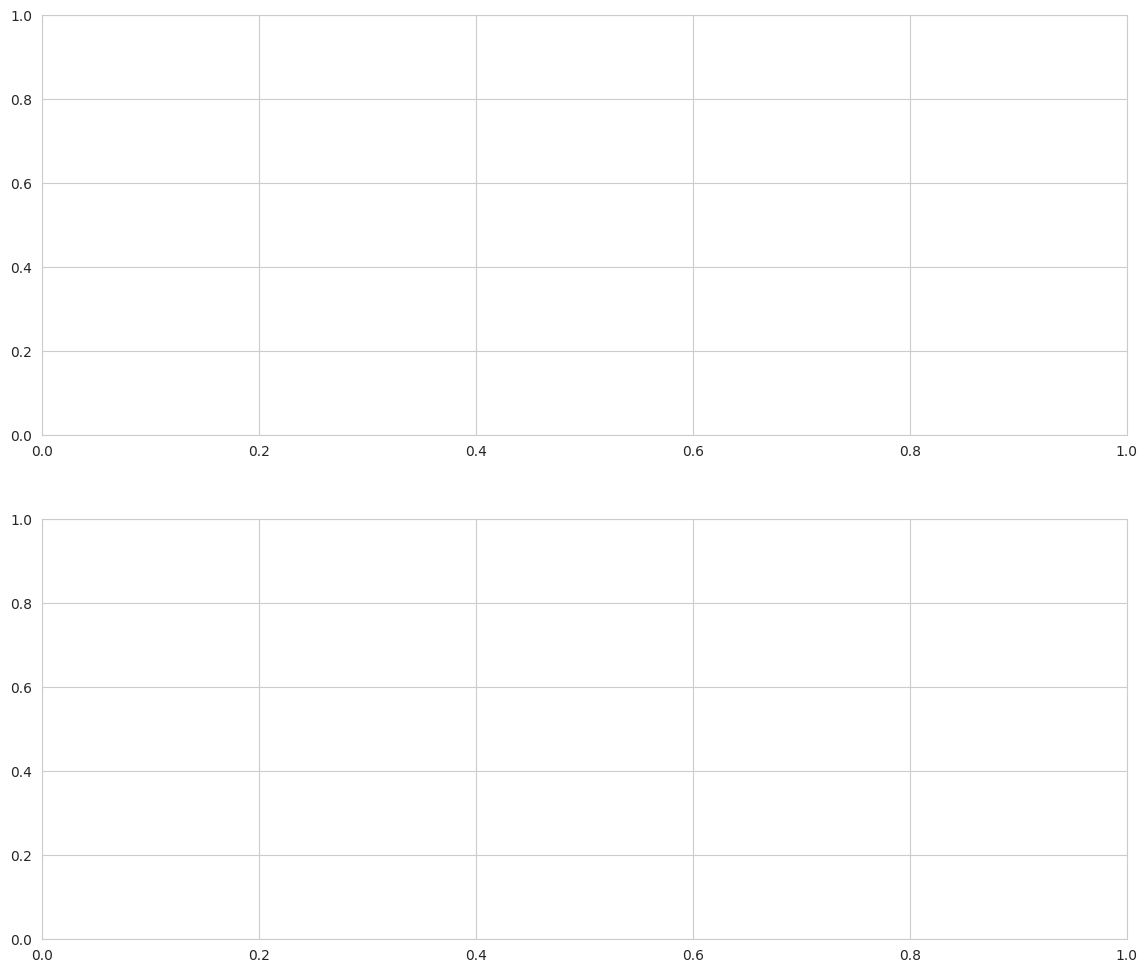

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Custom color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot 1: Absolute Payoff Distribution
for i, asset in enumerate(spot_prices.keys()):
    max_prices = np.max(paths[asset], axis=1)
    payoffs = np.maximum(max_prices - strike_prices[asset], 0)

    sns.kdeplot(payoffs, ax=ax1, color=colors[i],
                label=f"{asset} (Mean: ₹{np.mean(payoffs):,.2f})",
                linewidth=2.5, alpha=0.8)

    # Add vertical line at mean
    ax1.axvline(np.mean(payoffs), color=colors[i], linestyle='--', alpha=0.5)

ax1.set_title('Lookback Call Option Payoff Distributions', fontsize=14, pad=20)
ax1.set_xlabel('Absolute Payoff (INR)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.legend(fontsize=10, framealpha=1)
ax1.grid(True, alpha=0.3)

# Format x-axis with INR currency
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'₹{x:,.0f}'))

# Plot 2: Normalized Payoff Distribution
for i, asset in enumerate(spot_prices.keys()):
    max_prices = np.max(paths[asset], axis=1)
    payoffs = np.maximum(max_prices - strike_prices[asset], 0)
    normalized_payoffs = payoffs / spot_prices[asset]

    sns.kdeplot(normalized_payoffs, ax=ax2, color=colors[i],
                label=f"{asset} (Mean: {np.mean(normalized_payoffs):.2%})",
                linewidth=2.5, alpha=0.8)

    # Add vertical line at mean
    ax2.axvline(np.mean(normalized_payoffs), color=colors[i], linestyle='--', alpha=0.5)

ax2.set_title('Normalized Lookback Call Option Payoff Distributions', fontsize=14, pad=20)
ax2.set_xlabel('Payoff / Initial Spot Price', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend(fontsize=10, framealpha=1)
ax2.grid(True, alpha=0.3)

# Format x-axis as percentage
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Adjust layout and save
plt.tight_layout()
plt.savefig('lookback_payoff_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
def generate_price_paths_with_antithetic(S0, sigma, r, q, T, n_steps, n_simulations):

    np.random.seed(42)
    dt = T / n_steps
    paths = np.zeros((n_simulations, n_steps + 1))
    antithetic_paths = np.zeros((n_simulations, n_steps + 1))
    paths[:, 0] = S0
    antithetic_paths[:, 0] = S0

    for t in range(1, n_steps + 1):
        z = np.random.standard_normal(n_simulations)
        # Regular paths
        paths[:, t] = paths[:, t-1] * np.exp((r - q - 0.5 * sigma**2) * dt
                                           + sigma * np.sqrt(dt) * z)
        # Antithetic paths (using -z)
        antithetic_paths[:, t] = antithetic_paths[:, t-1] * np.exp(
            (r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * (-z))

    return paths, antithetic_paths

def floating_strike_lookback_antithetic(paths, antithetic_paths, option_type, r, T):

    # Calculate payoffs for regular and antithetic paths
    if option_type == 'call':
        min_prices = np.min(paths, axis=1)
        payoffs = paths[:, -1] - min_prices
        min_prices_anti = np.min(antithetic_paths, axis=1)
        payoffs_anti = antithetic_paths[:, -1] - min_prices_anti
    elif option_type == 'put':
        max_prices = np.max(paths, axis=1)
        payoffs = max_prices - paths[:, -1]
        max_prices_anti = np.max(antithetic_paths, axis=1)
        payoffs_anti = max_prices_anti - antithetic_paths[:, -1]
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Combine regular and antithetic payoffs
    combined_payoffs = 0.5 * (payoffs + payoffs_anti)
    price = np.exp(-r * T) * np.mean(combined_payoffs)
    std_error = np.std(combined_payoffs, ddof=1) / np.sqrt(len(combined_payoffs))

    return price, std_error

def fixed_strike_lookback_antithetic(paths, antithetic_paths, option_type, K, r, T):

    # Calculate payoffs for regular and antithetic paths
    if option_type == 'call':
        max_prices = np.max(paths, axis=1)
        payoffs = np.maximum(max_prices - K, 0)
        max_prices_anti = np.max(antithetic_paths, axis=1)
        payoffs_anti = np.maximum(max_prices_anti - K, 0)
    elif option_type == 'put':
        min_prices = np.min(paths, axis=1)
        payoffs = np.maximum(K - min_prices, 0)
        min_prices_anti = np.min(antithetic_paths, axis=1)
        payoffs_anti = np.maximum(K - min_prices_anti, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Combine regular and antithetic payoffs
    combined_payoffs = 0.5 * (payoffs + payoffs_anti)
    price = np.exp(-r * T) * np.mean(combined_payoffs)
    std_error = np.std(combined_payoffs, ddof=1) / np.sqrt(len(combined_payoffs))

    return price, std_error

In [ ]:
# Example usage for GOLD floating strike lookback call with antithetic variates
paths, anti_paths = generate_price_paths_with_antithetic(
    assets["GOLD"]["spot"],
    assets["GOLD"]["volatility"],
    risk_free_rate,
    assets["GOLD"]["dividend_yield"],
    time_to_maturity,
    n_steps=252,
    n_simulations=50000
)

price, std_err = floating_strike_lookback_antithetic(
    paths, anti_paths, 'call', risk_free_rate, time_to_maturity
)

print(f"Floating strike lookback call price: {price:.4f}")
print(f"Standard error: {std_err:.6f}")



Floating strike lookback call price: 43354.1447
Standard error: 65.924622


In [12]:
import time
import matplotlib.pyplot as plt

def compare_antithetic_performance(asset, option_type, strike_type, n_simulations_list, n_steps=100):

    # Get asset parameters
    params = assets[asset]
    S0 = params['spot']
    sigma = params['volatility']
    q = params['dividend_yield']
    r = risk_free_rate
    T = time_to_maturity

    # Get appropriate strike if fixed
    K = params['strike_ATM'] if strike_type == 'fixed' else None

    results = []

    for n_simulations in n_simulations_list:
        # Standard Monte Carlo
        start_time = time.time()
        paths = generate_price_paths(S0, sigma, r, q, T, n_steps, n_simulations)

        if strike_type == 'floating':
            price_std, std_err_std = floating_strike_lookback(paths, option_type, r, T)
        else:
            price_std, std_err_std = fixed_strike_lookback(paths, option_type, K, r, T)
        time_std = time.time() - start_time

        # Antithetic Monte Carlo
        start_time = time.time()
        paths, anti_paths = generate_price_paths_with_antithetic(S0, sigma, r, q, T, n_steps, n_simulations//2)

        if strike_type == 'floating':
            price_anti, std_err_anti = floating_strike_lookback_antithetic(paths, anti_paths, option_type, r, T)
        else:
            price_anti, std_err_anti = fixed_strike_lookback_antithetic(paths, anti_paths, option_type, K, r, T)
        time_anti = time.time() - start_time

        # Calculate variance reduction
        var_reduction = 1 - (std_err_anti**2 / std_err_std**2) if std_err_std > 0 else 0

        results.append({
            'n_simulations': n_simulations,
            'price_std': price_std,
            'std_err_std': std_err_std,
            'time_std': time_std,
            'price_anti': price_anti,
            'std_err_anti': std_err_anti,
            'time_anti': time_anti,
            'var_reduction': var_reduction,
            'price_diff': abs(price_std - price_anti),
            'time_ratio': time_anti/time_std if time_std > 0 else 1
        })

    # Create DataFrame
    df_results = pd.DataFrame(results)

    # Plot results
    plt.figure(figsize=(10, 7.5))

    # Timing comparison
    plt.subplot(2, 2, 1)
    plt.plot(df_results['n_simulations'], df_results['time_std'], label='Standard MC')
    plt.plot(df_results['n_simulations'], df_results['time_anti'], label='Antithetic MC')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Time (seconds)')
    plt.title('Computation Time Comparison')
    plt.legend()
    plt.grid(True)

    # Standard Error comparison
    plt.subplot(2, 2, 2)
    plt.plot(df_results['n_simulations'], df_results['std_err_std'], label='Standard MC')
    plt.plot(df_results['n_simulations'], df_results['std_err_anti'], label='Antithetic MC')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Standard Error')
    plt.title('Standard Error Comparison')
    plt.legend()
    plt.grid(True)

    # Price comparison
    plt.subplot(2, 2, 3)
    plt.plot(df_results['n_simulations'], df_results['price_std'], label='Standard MC')
    plt.plot(df_results['n_simulations'], df_results['price_anti'], label='Antithetic MC')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Option Price')
    plt.title('Price Estimation Comparison')
    plt.legend()
    plt.grid(True)

    # Variance reduction
    plt.subplot(2, 2, 4)
    plt.plot(df_results['n_simulations'], df_results['var_reduction'])
    plt.xlabel('Number of Simulations')
    plt.ylabel('Variance Reduction Ratio')
    plt.title('Variance Reduction Effectiveness')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return df_results

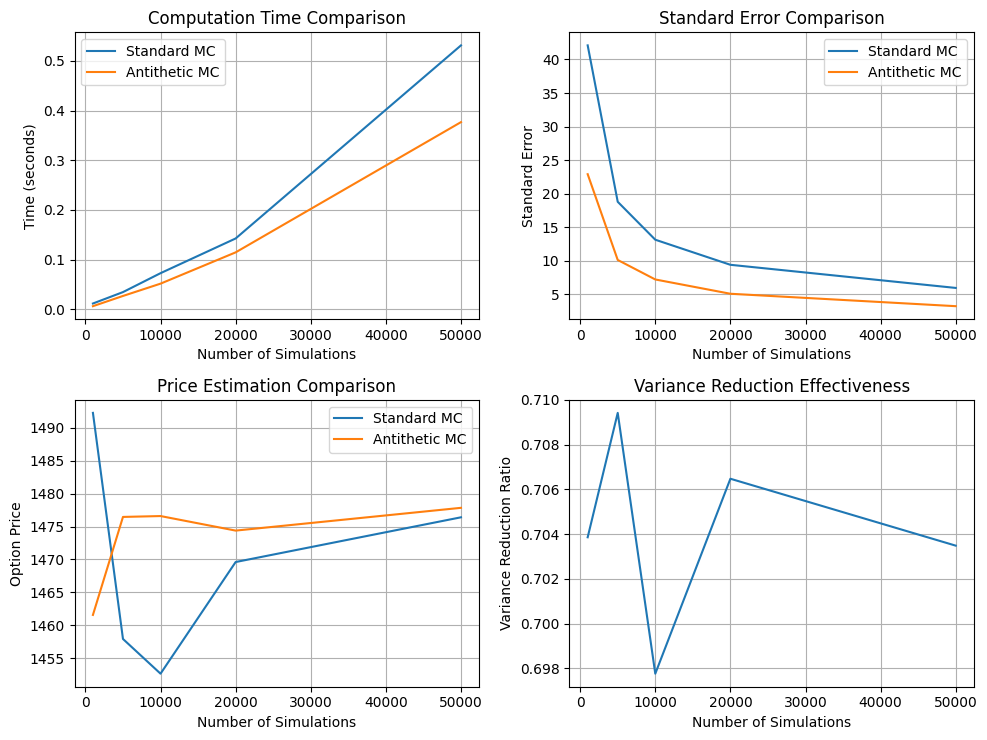


Performance Comparison Summary:
   n_simulations    price_std   price_anti  price_diff  std_err_std  \
0           1000  1492.289596  1461.573302   30.716294    42.100219   
1           5000  1457.918284  1476.470494   18.552210    18.800727   
2          10000  1452.640108  1476.603322   23.963214    13.151060   
3          20000  1469.613716  1474.392154    4.778438     9.414643   
4          50000  1476.413573  1477.854166    1.440593     5.969080   

   std_err_anti  var_reduction  time_std  time_anti  time_ratio  
0     22.910344       0.703862  0.011769   0.006390    0.542957  
1     10.134624       0.709420  0.034736   0.026972    0.776489  
2      7.229889       0.697767  0.072816   0.051731    0.710434  
3      5.100645       0.706477  0.142642   0.114699    0.804101  
4      3.250343       0.703487  0.531198   0.376770    0.709283  

Average Variance Reduction: 70.4%
Average Time Ratio (Antithetic/Standard): 0.71


In [13]:
# Compare performance for GOLD floating strike lookback call
simulation_counts = [1000, 5000, 10000, 20000, 50000]
results_df = compare_antithetic_performance(
    asset="GOLD",
    option_type="call",
    strike_type="floating",
    n_simulations_list=simulation_counts
)

# Display numerical results
print("\nPerformance Comparison Summary:")
print(results_df[['n_simulations', 'price_std', 'price_anti', 'price_diff',
                 'std_err_std', 'std_err_anti', 'var_reduction',
                 'time_std', 'time_anti', 'time_ratio']])

# Calculate average improvements
avg_var_reduction = results_df['var_reduction'].mean() * 100
avg_time_ratio = results_df['time_ratio'].mean()

print(f"\nAverage Variance Reduction: {avg_var_reduction:.1f}%")
print(f"Average Time Ratio (Antithetic/Standard): {avg_time_ratio:.2f}")

In [14]:
def calculate_errors(true_price, estimated_prices, estimated_std_errors):
    """
    Calculate various error metrics comparing estimated prices to a benchmark

    Parameters:
    true_price - benchmark price (could be analytical solution or high-precision MC)
    estimated_prices - array of estimated prices
    estimated_std_errors - array of corresponding standard errors

    Returns:
    Dictionary of error metrics
    """
    errors = {
        'absolute_errors': np.abs(estimated_prices - true_price),
        'relative_errors': np.abs((estimated_prices - true_price) / true_price),
        'bias': np.mean(estimated_prices - true_price),
        'rmse': np.sqrt(np.mean((estimated_prices - true_price)**2)),
        'std_error_ratios': estimated_std_errors / np.std(estimated_prices),
        'coverage_prob': np.mean(
            (estimated_prices - 1.96*estimated_std_errors <= true_price) &
            (estimated_prices + 1.96*estimated_std_errors >= true_price)
        )
    }
    return errors

In [16]:
def convergence_analysis(asset, option_type, strike_type, max_simulations=100000, step=5000):
    """
    Perform comprehensive convergence analysis for both standard and antithetic methods

    Parameters:
    asset - asset name from assets dictionary
    option_type - 'call' or 'put'
    strike_type - 'fixed' or 'floating'
    max_simulations - maximum number of simulations to test
    step - increment between simulation counts

    Returns:
    DataFrame with convergence metrics and plots
    """
    # Get asset parameters
    params = assets[asset]
    S0 = params['spot']
    sigma = params['volatility']
    q = params['dividend_yield']
    r = risk_free_rate
    T = time_to_maturity
    K = params['strike_ATM'] if strike_type == 'fixed' else None

    # Get high-precision benchmark (using 1M simulations with antithetic)
    print("Calculating high-precision benchmark...")
    benchmark_paths, benchmark_anti_paths = generate_price_paths_with_antithetic(
        S0, sigma, r, q, T, 252, 500000)

    if strike_type == 'floating':
        benchmark_price, _ = floating_strike_lookback_antithetic(
            benchmark_paths, benchmark_anti_paths, option_type, r, T)
    else:
        benchmark_price, _ = fixed_strike_lookback_antithetic(
            benchmark_paths, benchmark_anti_paths, option_type, K, r, T)

    print(f"Benchmark price: {benchmark_price:.6f}")

    # Initialize results storage
    simulation_counts = range(step, max_simulations+1, step)
    results = []

    # Run convergence tests
    for n_simulations in simulation_counts:
        # Standard MC
        paths = generate_price_paths(S0, sigma, r, q, T, 252, n_simulations)

        if strike_type == 'floating':
            price_std, std_err_std = floating_strike_lookback(paths, option_type, r, T)
        else:
            price_std, std_err_std = fixed_strike_lookback(paths, option_type, K, r, T)

        # Antithetic MC (using half the simulations for each path)
        paths, anti_paths = generate_price_paths_with_antithetic(S0, sigma, r, q, T, 252, n_simulations)

        if strike_type == 'floating':
            price_anti, std_err_anti = floating_strike_lookback_antithetic(
                paths, anti_paths, option_type, r, T)
        else:
            price_anti, std_err_anti = fixed_strike_lookback_antithetic(
                paths, anti_paths, option_type, K, r, T)

        # Store results
        results.append({
            'n_simulations': n_simulations,
            'price_std': price_std,
            'std_err_std': std_err_std,
            'price_anti': price_anti,
            'std_err_anti': std_err_anti,
        })

    # Create DataFrame
    df = pd.DataFrame(results)

    # Calculate error metrics
    df['abs_error_std'] = np.abs(df['price_std'] - benchmark_price)
    df['abs_error_anti'] = np.abs(df['price_anti'] - benchmark_price)
    df['rel_error_std'] = df['abs_error_std'] / benchmark_price
    df['rel_error_anti'] = df['abs_error_anti'] / benchmark_price

    # Plot convergence
    plt.figure(figsize=(15, 10))

    # Price convergence
    plt.subplot(2, 2, 1)
    plt.plot(df['n_simulations'], df['price_std'], label='Standard MC')
    plt.plot(df['n_simulations'], df['price_anti'], label='Antithetic MC')
    plt.axhline(benchmark_price, color='r', linestyle='--', label='Benchmark')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Option Price')
    plt.title('Price Convergence')
    plt.legend()
    plt.grid(True)



    # Standard error comparison
    plt.subplot(2, 2, 3)
    plt.loglog(df['n_simulations'], df['std_err_std'], label='Standard MC')
    plt.loglog(df['n_simulations'], df['std_err_anti'], label='Antithetic MC')
    plt.xlabel('Number of Simulations (log)')
    plt.ylabel('Standard Error (log)')
    plt.title('Standard Error Comparison (log-log)')
    plt.legend()
    plt.grid(True)

    # Error ratio
    plt.subplot(2, 2, 4)
    plt.plot(df['n_simulations'], df['abs_error_anti']/df['abs_error_std'])
    plt.axhline(1, color='r', linestyle='--')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Error Ratio (Antithetic/Standard)')
    plt.title('Relative Error Reduction')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return df, benchmark_price

Calculating high-precision benchmark...
Benchmark price: 1506.832767


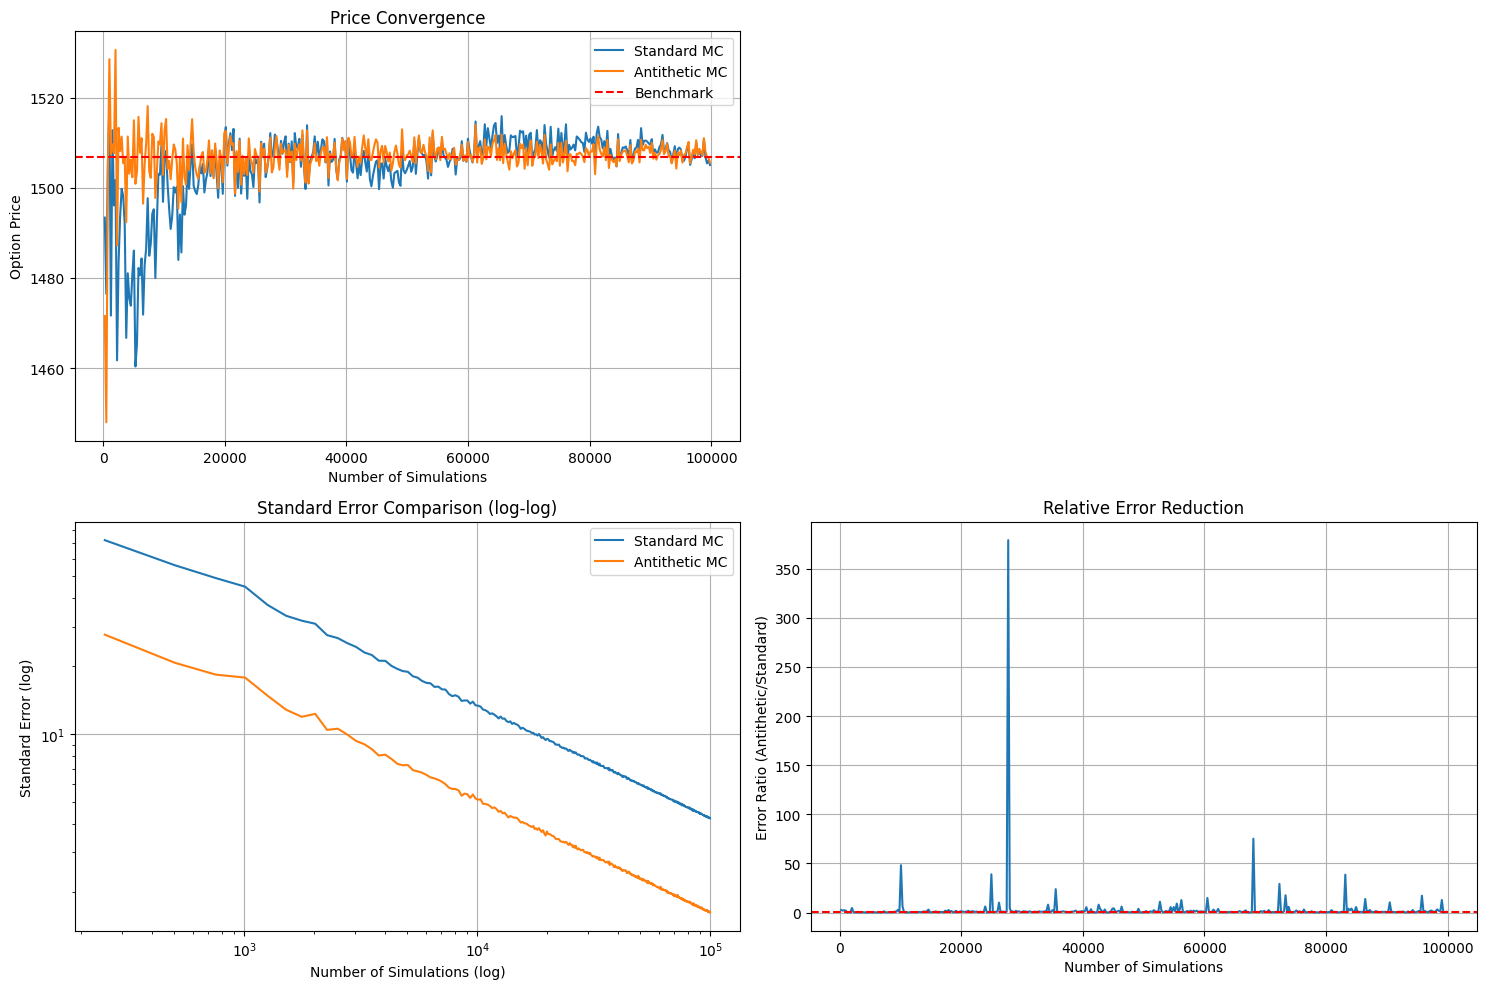


Final Benchmark Price: 1506.832767
Final Standard MC Error: 4.245810
Final Antithetic MC Error: 1.629774
Variance Reduction: 85.3%


In [17]:
# Run analysis for GOLD floating strike lookback call
gold_results, gold_benchmark = convergence_analysis(
    asset="GOLD",
    option_type="call",
    strike_type="floating",
    max_simulations=100000,
    step=252
)

# Calculate key metrics
final_std_error = gold_results['std_err_std'].iloc[-1]
final_anti_error = gold_results['std_err_anti'].iloc[-1]
variance_reduction = 1 - (final_anti_error**2 / final_std_error**2)

print(f"\nFinal Benchmark Price: {gold_benchmark:.6f}")
print(f"Final Standard MC Error: {final_std_error:.6f}")
print(f"Final Antithetic MC Error: {final_anti_error:.6f}")
print(f"Variance Reduction: {variance_reduction*100:.1f}%")

In [19]:
# Error statistics
print("\nError Statistics:")
print(f"Mean absolute error (Standard): {gold_results['abs_error_std'].mean():.6f}")
print(f"Mean absolute error (Antithetic): {gold_results['abs_error_anti'].mean():.6f}")
print(f"Maximum error reduction: {gold_results['abs_error_std'].max()/gold_results['abs_error_anti'].max():.2f}x")


Error Statistics:
Mean absolute error (Standard): 4.823192
Mean absolute error (Antithetic): 2.687763
Maximum error reduction: 0.79x


In [18]:
# Convergence rate analysis
log_errors_std = np.log(gold_results['abs_error_std'])
log_errors_anti = np.log(gold_results['abs_error_anti'])
log_n = np.log(gold_results['n_simulations'])

# Fit linear models to estimate convergence rates
beta_std = np.polyfit(log_n, log_errors_std, 1)[0]
beta_anti = np.polyfit(log_n, log_errors_anti, 1)[0]

print(f"\nEmpirical Convergence Rates:")
print(f"Standard MC: {beta_std:.3f} (expected ≈ -0.5)")
print(f"Antithetic MC: {beta_anti:.3f} (expected ≈ -0.5)")


Empirical Convergence Rates:
Standard MC: -0.660 (expected ≈ -0.5)
Antithetic MC: -0.475 (expected ≈ -0.5)
